# Trading at the Close - Feature Engineering
-----------------------
-----------------------

Feature selection involves picking the set of features that are most relevant to the target variable. This helps in reducing the complexity of the model, as well as minimizing the resources required for training and inference. This has greater effect in production models where one maybe dealing with terabytes of data or serving millions of requests.

Most of the modules will come from [scikit-learn](https://scikit-learn.org/stable/), one of the most commonly used machine learning libraries. It features various machine learning algorithms and has built-in implementations of different feature selection methods. Using these, you will be able to compare which method works best for this particular dataset.

## Installs
-----------

In [1]:
%pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Imports
------------------



In [2]:
# for data processing and manipulation
import pandas as pd
import numpy as np
from pathlib import Path

# scikit-learn modules for feature selection and model evaluation
from sklearn.metrics import mean_absolute_error 
from lightgbm import LGBMRegressor
import lightgbm as lgb
from loguru import logger
from pprint import pformat, pprint
from warnings import simplefilter  # Simplifying warning handling
import warnings

from utils.validation import TrainTestSplit

# libraries for visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

sns.set_style("ticks")

# 🤐 Disable warnings to keep the code clean
warnings.filterwarnings("ignore")
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

## Configuration
--------------------------

This cell defines the configuration to use throughout this notebook for feature selection.

In [3]:
class CFG:
    JOBS_PATH = Path(".", "job_artifacts")
    JOB_NAME = "optiver-feature_selection"
    TRAINING_PATH = Path(".", "train_files", "train.csv")
    AGGREGATIONS = "aggregations.json"
    SELECTED_FEATURES = "feature_names.json"
    COMPRESSED_TRAINING_DATA = "train_processed.parquet"
    TRAINING_DATA_STATS = "train_stats.csv"
    RANDOM_STATE = 1024
    USE_GPU = False
    MODEL = LGBMRegressor
    N_FOLDS = 1
    TEST_SIZE = 45
    N_JOBS = 1
    FEAT_COUNT= -1 # .-1 deactivates feature selection

In [4]:
def lgbm_params():
    """Returns algorithm parameters."""

    params = {
        "device"            : "gpu" if CFG.USE_GPU else "cpu",
        "objective"         : "mae",
        "boosting_type"     : "gbdt",
        "subsample"         : 0.8275174151277973,
        "min_child_samples" : 55,
        "colsample_bytree"  : 0.6605652916348981,
        "reg_alpha"         : 1.0314284418220028,
        "reg_lambda"        : 0.005619611631903648,
        "learning_rate"     : 0.02325401727630594,
        "max_depth"         : 9,
        "num_leaves"        : 319,
        "random_state"      : CFG.RANDOM_STATE,
        "n_jobs"            : CFG.N_JOBS
    }

    return params


MODEL_CFG = {
    LGBMRegressor.__name__ : {
        "params_func": lgbm_params,
        "callbacks": [lgb.early_stopping(25)]
    }
}


WEIGHTS = np.array([
    0.004, 0.001, 0.002, 0.006, 0.004, 0.004, 0.002, 0.006, 0.006, 0.002, 0.002, 0.008,
    0.006, 0.002, 0.008, 0.006, 0.002, 0.006, 0.004, 0.002, 0.004, 0.001, 0.006, 0.004,
    0.002, 0.002, 0.004, 0.002, 0.004, 0.004, 0.001, 0.001, 0.002, 0.002, 0.006, 0.004,
    0.004, 0.004, 0.006, 0.002, 0.002, 0.04 , 0.002, 0.002, 0.004, 0.04 , 0.002, 0.001,
    0.006, 0.004, 0.004, 0.006, 0.001, 0.004, 0.004, 0.002, 0.006, 0.004, 0.006, 0.004,
    0.006, 0.004, 0.002, 0.001, 0.002, 0.004, 0.002, 0.008, 0.004, 0.004, 0.002, 0.004,
    0.006, 0.002, 0.004, 0.004, 0.002, 0.004, 0.004, 0.004, 0.001, 0.002, 0.002, 0.008,
    0.02 , 0.004, 0.006, 0.002, 0.02 , 0.002, 0.002, 0.006, 0.004, 0.002, 0.001, 0.02,
    0.006, 0.001, 0.002, 0.004, 0.001, 0.002, 0.006, 0.006, 0.004, 0.006, 0.001, 0.002,
    0.004, 0.006, 0.006, 0.001, 0.04 , 0.006, 0.002, 0.004, 0.002, 0.002, 0.006, 0.002,
    0.002, 0.004, 0.006, 0.006, 0.002, 0.002, 0.008, 0.006, 0.004, 0.002, 0.006, 0.002,
    0.004, 0.006, 0.002, 0.004, 0.001, 0.004, 0.002, 0.004, 0.008, 0.006, 0.008, 0.002,
    0.004, 0.002, 0.001, 0.004, 0.004, 0.004, 0.006, 0.008, 0.004, 0.001, 0.001, 0.002,
    0.006, 0.004, 0.001, 0.002, 0.006, 0.004, 0.006, 0.008, 0.002, 0.002, 0.004, 0.002,
    0.04 , 0.002, 0.002, 0.004, 0.002, 0.002, 0.006, 0.02 , 0.004, 0.002, 0.006, 0.02,
    0.001, 0.002, 0.006, 0.004, 0.006, 0.004, 0.004, 0.004, 0.004, 0.002, 0.004, 0.04,
    0.002, 0.008, 0.002, 0.004, 0.001, 0.004, 0.006, 0.004,
])

Create the artifacts folder tree incrementally. Each run will correspond to a different folder.

In [5]:
CFG.JOBS_PATH.mkdir(exist_ok=True, parents=True)

for i in range(1, 10000):
    CFG.JOB_PATH = CFG.JOBS_PATH.joinpath(CFG.JOB_NAME + "-" +  str(i).zfill(4))
    try:
        CFG.JOB_PATH.mkdir()
        break
    except:
        continue

## Define Helper Functions
-------------------------

The following cells define helper functions for feature creation and selection.

In [6]:
%%writefile utils/features.py

import numpy as np
import pandas as pd
from itertools import combinations
from typing import List, Mapping, Any
from numba import njit

try:
    from loguru import logger
except:
    import logging
    logger = logging.getLogger("__main__")

from .compression import downcast
from .utils import merge_df


#==============================================================================

@njit
def moving_avg(arr: np.ndarray, window: int, min_periods: int = 1) -> np.ndarray:
    result = np.full(arr.shape, np.nan)  # Fill with nan
    if min_periods is None:
        min_periods = window

    for i in range(arr.shape[0]):
        windowed_data = arr[max(0, i - window + 1) : i + 1]
        valid_count = np.sum(~np.isnan(windowed_data))
        if valid_count >= min_periods:
            result[i] = np.nanmean(windowed_data)  # Compute mean considering possible NaN values

    return result


#==============================================================================

def get_moving_avg(x, lookback=10):
    x = x.to_numpy()
    return moving_avg(x, lookback)

#==============================================================================

@njit
def weighted_avg(values: np.ndarray, weights: np.ndarray):
    """
    Return the weighted average.

    values, weights -- NumPy ndarrays with the same shape.
    """
    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    return np.average(masked_values, weights=masked_weights)


#==============================================================================

def get_weighted_avg(x: pd.Series, weights: np.ndarray):

    stock_id = x["stock_id"]
    values = x.drop(columns=["stock_id"]).to_numpy().ravel()
    weights = weights[stock_id]

    return weighted_avg(values, weights)

#==============================================================================

@njit
def weighted_std(values, weights):
    """
    Return the weighted standard deviation.

    values, weights -- NumPy ndarrays with the same shape.
    """

    masked_values = values[~np.isnan(values)]
    masked_weights = weights[~np.isnan(values)]

    average = np.average(masked_values, weights=masked_weights)

    # Fast and numerically precise:
    variance = np.average((masked_values - average)**2, weights=masked_weights)
    return np.sqrt(variance)

#==============================================================================

def get_weighted_std(x: pd.Series, weights: np.ndarray):

    stock_id = x["stock_id"]
    values = x.drop(columns=["stock_id"]).to_numpy().ravel()
    weights = weights[stock_id]

    return weighted_std(values, weights)


"""

#==============================================================================

def get_rsi(x: pd.Series, length: int = 14):

    change = x.diff()
    gain = change.mask(change < 0, 0.0)
    loss = -change.mask(change > 0, -0.0)

    avg_gain = gain.ewm(alpha=1. / length, ignore_na=True).mean()
    avg_loss = loss.ewm(alpha=1. / length, ignore_na=True).mean()

    rsi = 100. - (100. / (1. + avg_gain / avg_loss))

    return rsi

#==============================================================================

def make_size_combs(df, sizes, total=True):
    for c in combinations(sizes, 2):
        print(c)
        df[f"{c[0]}.{c[1]}.spread"] = df[c[0]] - df[c[1]]
        df[f"{c[0]}.{c[1]}.imb1"] = (df[c[0]] - df[c[1]]) / (df[c[0]] + df[c[1]])
        df[f"{c[0]}.{c[1]}.ratio"] = df[c[0]] / df[c[1]]
        #df[f"{c[0]}.{c[1]}.hmean"] = (2. / ( 1. / df[c[0]] + 1. / df[c[1]]))# Harmonic mean
        if total:
            df[f"{c[0]}.{c[1]}.total"] = df[c[0]] + df[c[1]]

#==============================================================================

def make_price_combs(df, prices, mid_price=False):
    for c in combinations(prices, 2):
        df[f"{c[0]}.{c[1]}.spread"] = df[c[0]] - df[c[1]]
        df[f"{c[0]}.{c[1]}.imb1"] = (df[c[0]] - df[c[1]]) / (df[c[0]] + df[c[1]])
        #df[f"{c[0]}.{c[1]}.ratio"] = df[c[0]] / df[c[1]]

    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_

        df[f"{c[0]}.{c[1]}.{c[2]}.imb2"] = (max_ - mid_)/(mid_ - min_)
"""

#==============================================================================

def generate_time_features(df):

    pass
    #df["dow"] = df["date_id"] % 5  # Day of the week
    #df["seconds"] = df["seconds_in_bucket"] % 60  # Seconds
    #df["minute"] = df["seconds_in_bucket"] // 60  # Minutes


#==============================================================================

def generate_size_features(df):
    # Calculate various features
    df["bid_size.ask_size.total"] = df["ask_size"] + df["bid_size"]
    df["bid_size.ask_size.imbalance"] = (df["bid_size"] - df["ask_size"]) / (df["bid_size"] + df["ask_size"])
    df["imbalance_size.matched_size.imbalance"] = (df["imbalance_size"] - df["matched_size"]) / (df["matched_size"] + df["imbalance_size"])
    df["bid_size.ask_size.ratio"] = df["bid_size"] / df["ask_size"]


#==============================================================================

def generate_price_features(df):
    df["ask_price.bid_price.mean"] = (df["ask_price"] + df["bid_price"]) / 2
    df["ask_price.bid_price.spread"] = df["ask_price"] - df["bid_price"]
    df["far_price.near_price.spread"] = df["far_price"] - df["near_price"]

    # Create features for pairwise price imbalances
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    for c in combinations(prices, 2):
        df[f"{c[0]}.{c[1]}.imbalance"] = (df[c[0]] - df[c[1]])/(df[c[0]] + df[c[1]])

    # Calculate triplet imbalance features using the Numba-optimized function
    for c in combinations(prices, 3):
        max_ = df[list(c)].max(axis=1)
        min_ = df[list(c)].min(axis=1)
        mid_ = df[list(c)].sum(axis=1) - min_ - max_

        df[f"{c[0]}.{c[1]}.{c[2]}.imbalance"] = (max_ - mid_)/(mid_ - min_)

#==============================================================================

def generate_mixed_features(df: pd.DataFrame) -> None:

    # Calculate additional features
    df["prices.spread.imbalance_size.bid_price.product"] = df["ask_price.bid_price.spread"] * df["imbalance_size"] 
    df["prices.spread.sizes.imbalances.product"] = df["ask_price.bid_price.spread"] * df["bid_size.ask_size.imbalance"]
    df["prices.spread.product"] = df["ask_price.bid_price.spread"] * df["far_price.near_price.spread"]

#==============================================================================

def generate_rolling_features(df: pd.DataFrame, revealed_target: bool = True) -> None:

    df["imbalance_size.diff.matched_size.ratio"] = df.groupby("stock_id")["imbalance_size"].diff(periods=1) / df["matched_size"]
    df["ask_price.bid_price.spread.diff"] = df.groupby("stock_id")["ask_price.bid_price.spread"].diff()

    # Calculate shifted and return features for specific columns
    for col in ["matched_size", "imbalance_size", "reference_price", "imbalance_buy_sell_flag"]:
        for window in [1, 2, 3, 10]:
            df[f"{col}.shift.{window}"] = df.groupby("stock_id")[col].shift(window)
            df[f"{col}.pct_change.{window}"] = df.groupby("stock_id")[col].pct_change(window)
    
    # Calculate diff features for specific columns
    for col in ["ask_price", "bid_price", "ask_size", "bid_size"]:
        for window in [1, 2, 3, 10]:
            df[f"{col}.diff.{window}"] = df.groupby("stock_id")[col].diff(window)    

    # Add revealed target
    df[f"revealed_target"] = df.groupby(["stock_id", "seconds_in_bucket"])["target"].shift(1)


#==============================================================================


def generate_aggregated_features(df: pd.DataFrame, global_stock_aggregations: Mapping[int, Any] = None, weights: List[float] = None) -> None:

    apply_engine = "numba"
    sample = df.groupby(["date_id", "seconds_in_bucket"])

    # Calculate various statistical aggregation features
    sizes = ["matched_size", "bid_size", "ask_size", "imbalance_size"]
    prices = ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"]
    for func in ["mean", "std", "skew", "kurt"]:
        df[f"all_prices.{func}.aggr"] = df[prices].aggregate(func, axis=1)
        df[f"all_sizes.{func}.aggr"] = df[sizes].aggregate(func, axis=1)

    # Map global features to the DataFrame
    if global_stock_aggregations is not None:
        for key, value in global_stock_aggregations.items():
            df[f"{key}.global_aggr"] = df["stock_id"].map(value.to_dict())


    date_aggregations = {}

    for size in sizes:
        date_aggregations[size + ".mean"] = sample[size].mean(engine=apply_engine).to_dict()
        date_aggregations[size + ".std" ] = sample[size].std(engine=apply_engine).to_dict()

    for price in prices:
        if weights is not None:
            date_aggregations[price + ".mean.weighted"] = sample[[price, "stock_id"]].apply(lambda x: get_weighted_avg(x, weights=weights)).to_dict()
            date_aggregations[price + ".std.weighted"] = sample[[price, "stock_id"]].apply(lambda x: get_weighted_std(x, weights=weights)).to_dict()

        else:
            date_aggregations[price + ".mean"] = sample[price].mean(engine=apply_engine).to_dict()
            date_aggregations[price + ".std"] = sample[price].std(engine=apply_engine).to_dict()


    # Perform aggregations and features dependent on these
    logger.info("Applying date-wise aggregations...")
    for key, value in date_aggregations.items():
        aggr_index = ["date_id", "seconds_in_bucket"]
        aggr_colum = pd.Series(value, name=key + ".date_aggr")
        aggr_colum.index = aggr_colum.index.set_names(aggr_index)
        df = merge_df(df, aggr_colum, on=aggr_index)



#==============================================================================

def generate_global_features(df: pd.DataFrame) -> None:

    apply_engine = "numba"

    global_stock_id_feats = {
        "size.median": df.groupby("stock_id")["bid_size"].mean(engine=apply_engine) + df.groupby("stock_id")["ask_size"].mean(engine=apply_engine),
        "size.std": df.groupby("stock_id")["bid_size"].std(engine=apply_engine) + df.groupby("stock_id")["ask_size"].std(engine=apply_engine),
        "size.ptp": df.groupby("stock_id")["bid_size"].max(engine=apply_engine) - df.groupby("stock_id")["bid_size"].min(engine=apply_engine),
        "price.median": df.groupby("stock_id")["bid_price"].mean(engine=apply_engine) + df.groupby("stock_id")["ask_price"].mean(engine=apply_engine),
        "price.std": df.groupby("stock_id")["bid_price"].std(engine=apply_engine) + df.groupby("stock_id")["ask_price"].std(engine=apply_engine),
        "price.ptp": df.groupby("stock_id")["bid_price"].max(engine=apply_engine) - df.groupby("stock_id")["ask_price"].min(engine=apply_engine),
    }

    return global_stock_id_feats

#==============================================================================

# Function to do the feature engineering
def feature_engineering(
    df: pd.DataFrame, 
    global_stock_aggregations: Mapping[int, Any] = None, 
    weights: List[float] = None,
    revealed_target: bool = True, 
    reduce_memory: bool = True
) -> None:

    ########################
    # Time features
    ########################
    logger.info("Generating time features...")
    generate_time_features(df)

    ########################
    # Size-only features
    ########################
    logger.info("Generating size features...")
    generate_size_features(df)

    ########################
    # Price-only features
    ########################
    logger.info("Generating price features...")
    generate_price_features(df)

    ########################
    # Mixed features
    ########################
    logger.info("Generating mixed features...")
    generate_mixed_features(df)

    ########################
    # Aggregated features
    ########################
    logger.info("Generating aggregated features...")
    generate_aggregated_features(df, global_stock_aggregations, weights)

    ########################
    # Rolling features
    ########################
    logger.info("Generating rolling features...")
    generate_rolling_features(df, revealed_target)

    ########################
    # A bit of cleaning
    ########################
    # Replace infinite values with nulls
    #df.replace([np.inf, -np.inf], 0)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df


#==============================================================================

"""
def make_features(df: pd.DataFrame, reduce_memory: bool = True) -> None:

    logger.info("Creating additional features...")

    # Volumes
    #df["ask_volume"] = df["ask_size"] * df["ask_price"]
    #df["bid_volume"] = df["bid_size"] * df["bid_price"]
    #df["spread_volume"] =  df.eval("ask_volume - bid_volume", engine=eval_engine)
    #df["total_volume"] = df.eval("ask_volume + bid_volume", engine=eval_engine)
    #df["ratio_volume"] = df.eval("bid_volume / ask_volume", engine=eval_engine)

    # Size features
    df["total_size"] = df["ask_size"] + df["bid_size"]
    df["ratio_size"] = df["bid_size"] / df["ask_size"]
    df["imb_s1"] = (df["bid_size"] - df["ask_size"])/(df["bid_size"] + df["ask_size"])

    # Imbalance features
    df["imb_ratio"] = df["imbalance_size"] / df["matched_size"]
    df["imb_spread"] = df["imbalance_size"] - df["matched_size"]
    df["imb_s2"] = (df["imbalance_size"] - df["matched_size"])/(df["matched_size"] + df["imbalance_size"])

    #make_size_combs(df, ["ask_size", "bid_size"], total=True)
    #make_size_combs(df, ["imbalance_size", "matched_size"])
    make_price_combs(df, ["reference_price", "far_price", "near_price", "ask_price", "bid_price", "wap"])

    # Encode imbalance flag as separate features
    df_encoded = pd.get_dummies(df["imbalance_buy_sell_flag"])
    df_encoded = df_encoded.rename(columns={
        -1: "sell_side_imbalance", 
        0 : "neutral_imbalance", 
        1: "buy_side_imbalance"
    }).astype(np.int8).drop(columns=["neutral_imbalance"])

    df = pd.concat([df, df_encoded], axis=1)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df

#==============================================================================

def make_aggregated_features(df: pd.DataFrame, weights: List[float] = None, reduce_memory: bool = False):

    if not isinstance(weights, np.ndarray):
        weights = np.array(weights)

    apply_engine = "numba"
    sample = df.groupby(["date_id", "seconds_in_bucket"], group_keys=False, sort=False)

    date_aggregations = {}

    sizes = ["ask_size.bid_size.imb1", "imbalance_size.matched_size.imb1"]
    for size in sizes:
        date_aggregations[size + ".mean"] = sample[size].mean(engine=apply_engine).to_dict()
        date_aggregations[size + ".std" ] = sample[size].std(engine=apply_engine).to_dict()

    prices = ["wap", "reference_price", "ask_price", "bid_price"]
    for price in prices:
        if weights is not None:
            date_aggregations[price + ".mean.weighted"] = sample[[price, "stock_id"]].apply(lambda x: get_weighted_avg(x, weights=weights)).to_dict()
            date_aggregations[price + ".std.weighted"] = sample[[price, "stock_id"]].apply(lambda x: get_weighted_std(x, weights=weights)).to_dict()

        else:
            date_aggregations[price + ".mean"] = sample[price].mean(engine=apply_engine).to_dict()
            date_aggregations[price + ".std"] = sample[price].std(engine=apply_engine).to_dict()


    # Perform aggregations and features dependent on these
    logger.info("Applying date-wise aggregations...")
    for key, value in date_aggregations.items():
        aggr_index = ["date_id", "seconds_in_bucket"]
        aggr_colum = pd.Series(value, name=key + "_date_aggr")
        aggr_colum.index = aggr_colum.index.set_names(aggr_index)
        df = pd.merge(df, aggr_colum, on=aggr_index)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df

#==============================================================================


def make_rolling_features(df: pd.DataFrame, windows: List[float] = [12, 24, 36, 48], reduce_memory: bool = True) -> None:

    apply_engine = "numba"

    sample_date = df.groupby(["stock_id", "seconds_in_bucket"])
    # Add lagged target
    df[f"revealed_target"] = sample_date["target"].shift(1)

    sample_stock = df.groupby(["stock_id"])
    prices = ["reference_price", "ask_price", "bid_price", "wap"]
    
    # Adding previous date target as feature
    for window in windows:
        for elem in prices:
            df[f"{elem}.SMA.window{window * 10}"] = sample_stock[elem].rolling(window, min_periods=1).mean(engine=apply_engine)
            df[f"{elem}.std.window{window * 10}"] = sample_stock[elem].rolling(window, min_periods=1).std(engine=apply_engine)

    for elem in prices:
        df[f"{elem}.MACD"] = (sample_stock[elem].ewm(12, ignore_na=True).mean() - \
                              sample_stock[elem].ewm(26, ignore_na=True).mean()).reset_index()[elem]
        
        df[f"{elem}.RSI"] = sample_stock[elem].apply(get_rsi).reset_index()[elem]

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df
"""

#==============================================================================

def select_features(df: pd.DataFrame, features: List[str] = None, reduce_memory: bool = True) -> None:
    """This function dorps features. Works fully in memory"""

    if features is not None:
        logger.info("Dropping unnecesary features...")
        df.drop(columns=[elem for elem in df.columns if elem not in features], inplace=True)

    if reduce_memory:
        logger.info("Reducing data memory footprint...")
        downcast(df)

    return df

#==============================================================================

def clean_dataset(df: pd.DataFrame) -> None:
    """This function cleans the dataset row-wise. Works fully in memory"""

    logger.info("Cleaning dataset...")

    # Drop all nans rows in target 
    df.dropna(subset="target", inplace=True)

    # Reset infex in-place
    df.reset_index(drop=True, inplace=True)

#==============================================================================


Overwriting utils/features.py


## Dataset Loading
------------------

The following cell loads a memory optimized version of the training dataset and saves it to Parquet format for better IO operations.

In [7]:
df = pd.read_csv(CFG.TRAINING_PATH)

# Describe data statistics
df.describe(include="all")

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06,5.237980e+06,5237980
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5237980
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0_0_0
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
mean,9.928856e+01,2.415100e+02,2.700000e+02,5.715293e+06,-1.189619e-02,9.999955e-01,4.510025e+07,1.001713e+00,9.996601e-01,9.997263e-01,5.181359e+04,1.000264e+00,5.357568e+04,9.999920e-01,-4.756125e-02,1.331005e+04,NaN
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00,7.619271e+03,NaN
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02,0.000000e+00,NaN
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279575e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00,6.729000e+03,NaN
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02,1.334500e+04,NaN
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00,1.990700e+04,NaN


Extract the training data subset to calculate historic values from there.

In [8]:
# Get an extract of the training dataset
cv = TrainTestSplit(CFG.TEST_SIZE)
for i, (train_index, val_index) in enumerate(cv.split(df, date_id=df["date_id"])):
    df_train = df.iloc[train_index]
    break

## Feature Engineering
-----------------------


### Creation of New Features

Create new features that are combination of others and aggregate others. These will be analysed during the feature selection process to end up with the most relevant ones.

In [10]:
from utils.features import feature_engineering, generate_global_features

# Get global values only from training dataset
global_stock_aggregations = generate_global_features(df_train)

# Create new features
df = feature_engineering(df, global_stock_aggregations, WEIGHTS, revealed_target=True, reduce_memory=True)

df.dtypes

2023-11-02 23:06:30.168 | INFO     | utils.features:feature_engineering:290 - Generating time features...
2023-11-02 23:06:30.168 | INFO     | utils.features:feature_engineering:296 - Generating size features...
2023-11-02 23:06:30.319 | INFO     | utils.features:feature_engineering:302 - Generating price features...
2023-11-02 23:07:12.000 | INFO     | utils.features:feature_engineering:308 - Generating mixed features...
2023-11-02 23:07:12.069 | INFO     | utils.features:feature_engineering:314 - Generating aggregated features...


### Remove Unwanted Features

You can remove features that are not needed when making predictions. The `row_id` is just an string assigned to records and has nothing to do with the target. It is a composition of other columns to uniquely identify the record. The `time_id` column is highly correlated with `date_id`, therefore it is also going to be removed.

In [ ]:
from utils.features import select_features

# Remove "row_id", "time_id" and "date_id" as it is unnecessary
date_id = df["date_id"]

drop_features = ["row_id", "time_id", "date_id"]
selected_features = [elem for elem in df.columns if elem not in drop_features]
df = select_features(df, features=selected_features, reduce_memory=True)

# Check that the columns are indeed dropped
df.head()

2023-11-02 21:57:55.217 | INFO     | utils.features:select_features:428 - Dropping unnecesary features...
2023-11-02 21:57:58.227 | INFO     | utils.features:select_features:432 - Reducing data memory footprint...
2023-11-02 21:57:58.235 | INFO     | utils.compression:downcast:16 - Memory usage of dataframe is 3496.73 MB
2023-11-02 21:58:48.488 | INFO     | utils.compression:downcast:25 - Memory usage after optimization is: 3496.73 MB
2023-11-02 21:58:48.522 | INFO     | utils.compression:downcast:27 - Decreased by 0.00%


,stock_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,bid_price.diff.10,ask_size.diff.1,ask_size.diff.2,ask_size.diff.3,ask_size.diff.10,bid_size.diff.1,bid_size.diff.2,bid_size.diff.3,bid_size.diff.10,revealed_target
0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Clean the Dataset

Most decision tree-based algorithms are robust to invalid (NaN) values in input features, but having an invalid dependent variable is useless in this case. This is why rows with invalid `target` are dropped. Apart from this, the decision tree will fail in the presence of an infinity value.

In [ ]:
from utils.features import clean_dataset

clean_dataset(df)

# Check if there are null values in any of the columns. Target (which is the dependent variable) should display 0 now.
logger.info("NaN count after cleaning: ")
df.isna().sum()

2023-11-02 21:58:48.709 | INFO     | utils.features:clean_dataset:442 - Cleaning dataset...


2023-11-02 21:58:51.594 | INFO     | __main__:<module>:6 - NaN count after cleaning: 


stock_id                       0
seconds_in_bucket              0
imbalance_size               132
imbalance_buy_sell_flag        0
reference_price              132
                           ...  
bid_size.diff.1              200
bid_size.diff.2              400
bid_size.diff.3              600
bid_size.diff.10            2000
revealed_target            11088
Length: 127, dtype: int64


Save a compressed version of the preprocessed training dataset, together with some artifacts.

In [ ]:
from utils.files import dump_json

#df.to_parquet(CFG.JOB_PATH.joinpath(CFG.COMPRESSED_TRAINING_DATA))
df.describe(include="all").to_csv(CFG.JOB_PATH.joinpath(CFG.TRAINING_DATA_STATS))

#dump_json(CFG.JOB_PATH.joinpath(CFG.AGGREGATIONS), aggregations, indent=4)

### Preliminary Model Training and Performance Evaluation


Next, split the dataset into feature vectors `X` and target vector `Y` to fit a [LightGBM](https://lightgbm.readthedocs.io/en/stable/) regressor. This is done to compare the performance of each feature selection technique, using [Mean Absolute Error](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html) as evaluation metric.

In [ ]:
# Split feature and target vectors
Y = df["target"]
X = df.drop(columns=["target"])

### Fit the Model and Perform Feature Selection based on Feature Importance (Embedded Methods)

Some models already have intrinsic properties that select the best features when it is constructed. With that, you can simply access these properties to get the scores for each feature. Let's look at some examples in the following sections.

In [ ]:
from utils.validation import cross_validate

model_cls = CFG.MODEL
model_cfg = MODEL_CFG[CFG.MODEL.__name__]
param_space_func = model_cfg["params_func"]
callbacks_func = model_cfg["callbacks"]

scores, trained_models = cross_validate(
    model_type=CFG.MODEL,
    model_params=param_space_func(),
    x=X,
    y=Y,
    date_id=date_id,
    scorer=mean_absolute_error,
    cv=TrainTestSplit(test_size=CFG.TEST_SIZE, n_splits=CFG.N_FOLDS),
    categorical_feature=["imbalance_buy_sell_flag"],
    callbacks=callbacks_func,
    job_path=CFG.JOB_PATH
)

2023-11-02 22:23:21.859 | INFO     | utils.validation:cross_validate:82 - Starting evaluation...
2023-11-02 22:23:21.867 | INFO     | utils.validation:cross_validate:83 - ==============================
2023-11-02 22:24:18.098 | INFO     | utils.validation:cross_validate:94 - Model trained with seed 1847


[LightGBM] [Warning] Met negative value in categorical features, will convert it to NaN
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 6.088369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 28534
[LightGBM] [Info] Number of data points in the train set: 4742980, number of used features: 126
[LightGBM] [Info] Start training from score -0.060201
Training until validation scores don't improve for 25 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l1: 5.85519


2023-11-02 22:34:15.790 | INFO     | utils.validation:cross_validate:106 - Fold 1: 5.8552 (took 590.54s)
2023-11-02 22:34:16.437 | INFO     | utils.validation:cross_validate:113 - ------------------------------
2023-11-02 22:34:16.438 | SUCCESS  | utils.validation:cross_validate:114 - Average MAE = 5.8552 ± 0.00
2023-11-02 22:34:16.443 | INFO     | utils.validation:cross_validate:115 - ==============================



**Feature importance** is already built-in in scikit-learn’s tree based models like **RandomForestClassifier** and typical gradient boosting algorithms such as **LGBMRegressor**. Once the model is fit, the feature importance is available as a property named **feature_importances_**.

One can simply use [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html) to select features from the trained model based on a given threshold. It can also be done manually, in particular when the cross-validation involves several models.

<Axes: >

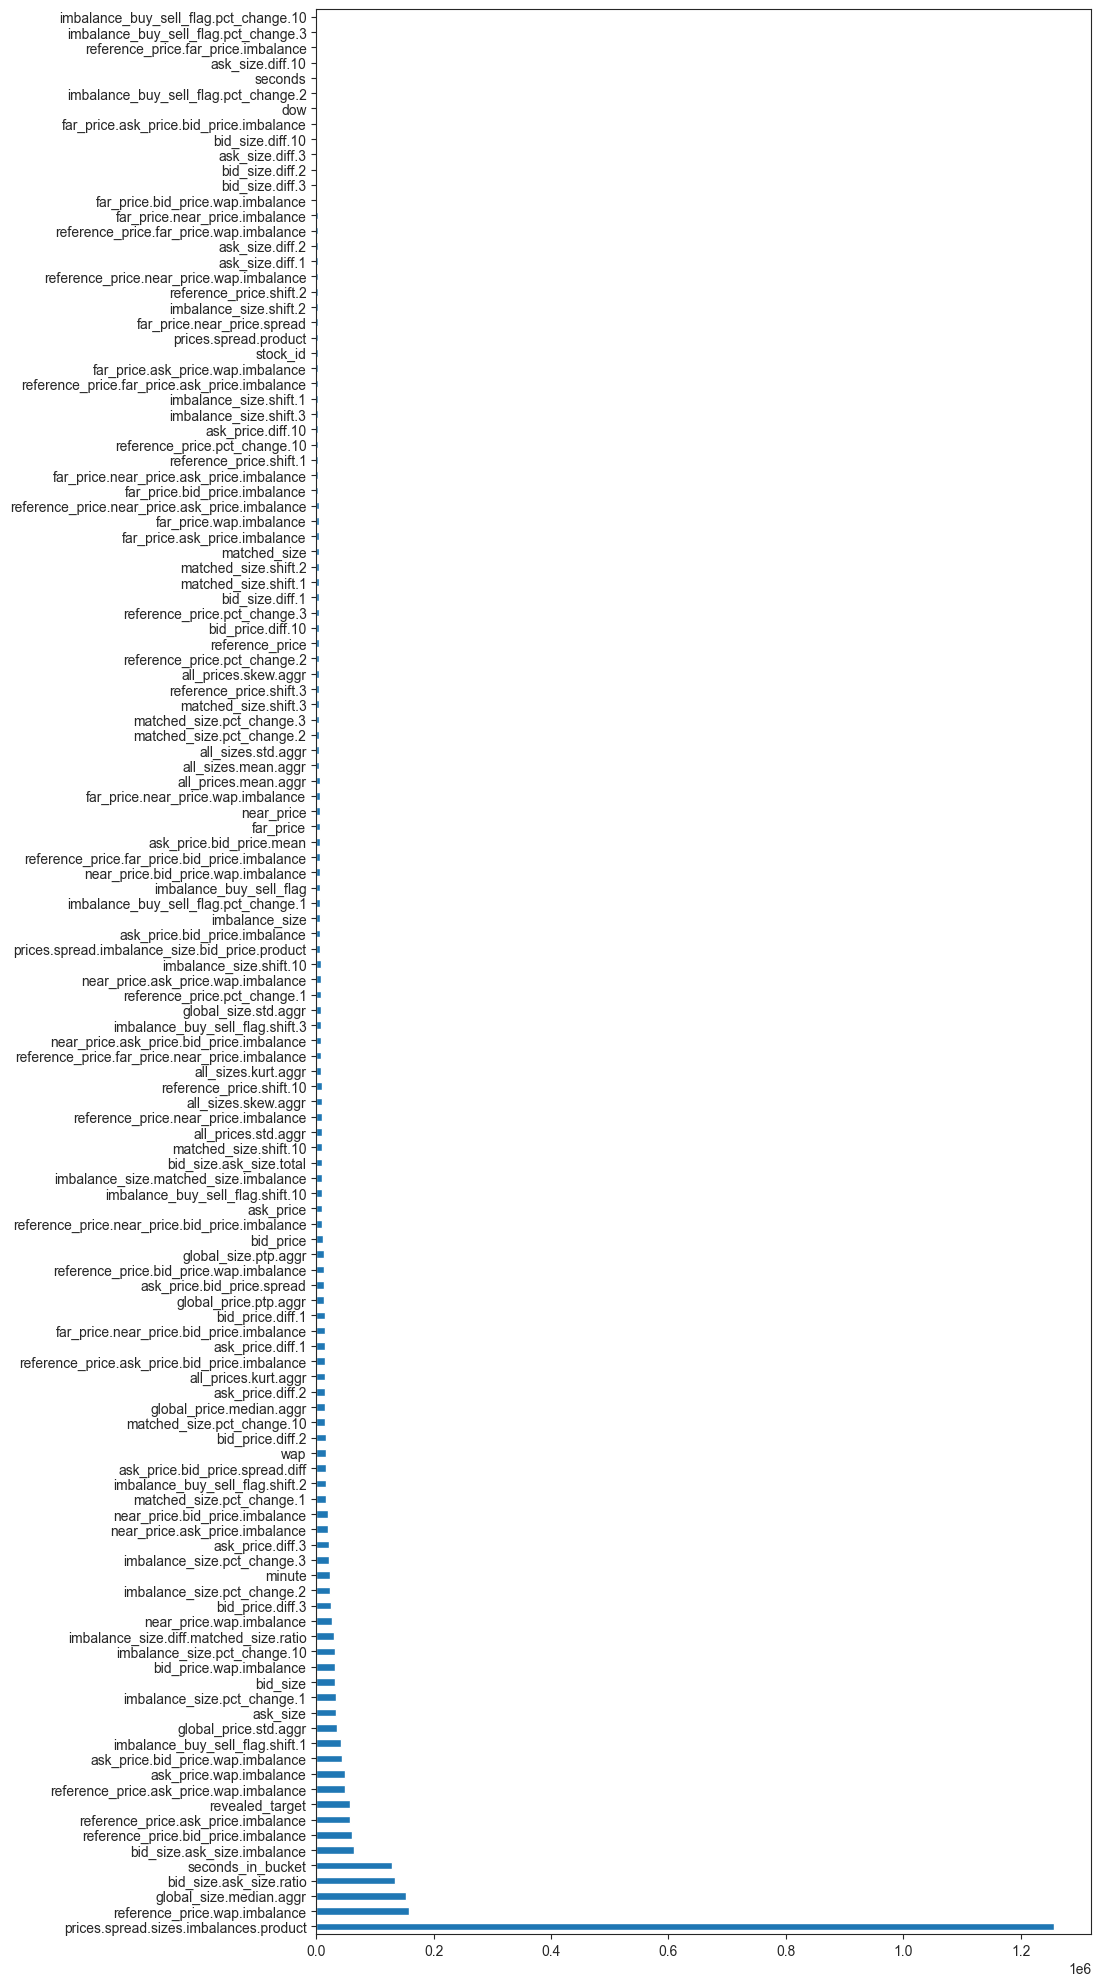

In [ ]:
agreggated_feature_importances = (sum([model.booster_.feature_importance(importance_type="gain") \
                                       for model in trained_models])/len(trained_models)).astype(np.int32)

agreggated_feature_importances = pd.Series(agreggated_feature_importances, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 25))
agreggated_feature_importances.plot(kind='barh')

In [ ]:
from utils.files import dump_json

if CFG.FEAT_COUNT > 0:
    selected_features = list(agreggated_feature_importances.index[:CFG.FEAT_COUNT]) # Select the desired results
else:
    selected_features = list(df.columns) # Select all

# Add essential features if not in the selected features
selected_features.extend(["stock_id", "seconds_in_bucket"])
selected_features = list(dict.fromkeys(selected_features))

logger.info("Selected features are: ")
pprint(selected_features)

selected_features_dict = {"selected_features": selected_features,
                          "stock_weights": WEIGHTS}
dump_json(CFG.JOB_PATH.joinpath(CFG.SELECTED_FEATURES), selected_features_dict, indent=4)

2023-11-01 22:34:21.104 | INFO     | __main__:<module>:13 - Selected features are: 


['stock_id',
 'seconds_in_bucket',
 'imbalance_size',
 'reference_price',
 'matched_size',
 'far_price',
 'near_price',
 'bid_price',
 'bid_size',
 'ask_price',
 'ask_size',
 'wap',
 'target',
 'total_size',
 'ratio_size',
 'imb_s1',
 'imb_ratio',
 'imb_spread',
 'imb_s2',
 'ask_price.bid_price.spread',
 'ask_price.bid_price.imb1',
 'ask_price.reference_price.spread',
 'ask_price.reference_price.imb1',
 'ask_price.wap.spread',
 'ask_price.wap.imb1',
 'ask_price.far_price.spread',
 'ask_price.far_price.imb1',
 'ask_price.near_price.spread',
 'ask_price.near_price.imb1',
 'bid_price.reference_price.spread',
 'bid_price.reference_price.imb1',
 'bid_price.wap.spread',
 'bid_price.wap.imb1',
 'bid_price.far_price.spread',
 'bid_price.far_price.imb1',
 'bid_price.near_price.spread',
 'bid_price.near_price.imb1',
 'reference_price.wap.spread',
 'reference_price.wap.imb1',
 'reference_price.far_price.spread',
 'reference_price.far_price.imb1',
 'reference_price.near_price.spread',
 'reference_